In [32]:
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import fullmodel_v1_7
import pandas as pd
from Extract_data import extractData
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from multiprocess import Pool
import os
import time
import copy

In [33]:
# Define your ODE function

# Initial conditions
M_0 = 0
A_0 = 0.5
B_0 = 0.004  # 0.004
Q_B_0 = 0.01
Q_A_0 = 0.01
P_0 = 0.7  # 10
D_0 = 0.0239  # 0.0239
Y_0 = 0.025
W_0 = 0.02
O_0 = 7
v_A_0 = 0
v_D_0 = 0
v_Y_0 = 0
v_W_0 = 0


initial_conditions = [M_0, B_0, A_0,
                      Q_B_0,
                      Q_A_0, P_0,
                      D_0,
                      Y_0, W_0,
                      v_A_0, v_D_0,
                      v_Y_0, v_W_0, O_0]


# Data
year = "2021"
data = pd.read_excel("all-bloom-indicators.xlsx")

lake_name = "Pigeon Lake"

data = data[data["Waterbody name"] == lake_name]

data_fit = extractData(data, year)




def read_params():
    model_CyB = fullmodel_v1_7.modelCyB()
    model_CyB.initial = initial_conditions
    name_data_param = "fitting_parameters_full_variables_v1"
    coment = "_v1_7_"
    name_data = './New data/'+lake_name + '/' \
        + name_data_param + year + lake_name+coment \
        + "_final" + ".csv"

    params_fit = pd.read_csv(name_data)

    # params_fit = pd.read_csv(
    #     "fitting_parameters_full_variables_v12021Pine Lake_v2__final.csv")
    unknow_params = ["e_BD", "alpha_B", "alpha_D",
                     "alpha_Y",
                     "tau_B", "tau_D", "tau_Y",
                     "a_A", "a_D", "sigma_A",
                     "sigma_D", "x_A", "x_D"]

    model_CyB.initial[1] = params_fit["B_0"][0]
    model_CyB.initial[2] = params_fit["A_0"][0]
    model_CyB.initial[6] = params_fit["D_0"][0]

    for name in unknow_params:
        model_CyB.params[name] = params_fit[name][0]

    # Death Daphnia
    model_CyB.params['n_D'] = 0.0623
    model_CyB.params['e_BD'] = 0.8
    model_CyB.params["tau_B"] = 1.23
    model_CyB.params["alpha_B"] = 0.0035
    # model_CyB.params["tau_Y"] = 1.23
    # # model_CyB.params["tau_D"] = 0.01
    # model_CyB.params["alpha_D"] = 0.003941
    # model_CyB.params['phi_D'] = 700
    # model_CyB.params['phi_Y'] = 700

    model_CyB.params['r_Y'] = 2
    model_CyB.params['r_W'] = 1
    model_CyB.params['Ext_Y'] = 0.025*13
    model_CyB.params['Ext_W'] = 0.025
    # model_CyB.params['p_in'] = 0.15*2

    # With Toxine
    model_CyB.toxines = True and (model_CyB.initial[1] > 0)
    # New time scale
    # days_before = 15

    # days_after = 60

    model_CyB.t_0 = 0

    # model_CyB.t_f = t_data.max()-t_data.min() + days_after

    model_CyB.t_f = 365

    model_CyB.delta_t = model_CyB.t_f*3

    model_CyB.set_linetime()

    t_data = data_fit["days"].values

    # Temperature

    model_CyB.max_temp_time = 197.3989-20

    return model_CyB

C:\Users\brian\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["Total cyanobacterial cell count (cells/mL)Tra"] = transformCyB(
C:\Users\brian\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["days"] = data_mean_year.index.dayofyear


In [40]:

####### Plots ###############
threhold = 10


####### Color_map##########
# map_color = "tab10"
map_color = "inferno"
# map_color = 'cool'

sns.set_style('ticks')
sns.plotting_context("paper", font_scale=1.5)

######## Some function to measure ##########


def days_before_after_toxin(M_values, threhold):
    # Find indices where elements are greater than b
    greater_than_b_indices = np.where(M_values > threhold)[0]

    if len(greater_than_b_indices) == 0:
        return None, None  # No elements greater than b

    # First index where element is greater than b
    x_0 = greater_than_b_indices[0]

    # Last index where element is greater than b
    x_1 = greater_than_b_indices[-1]

    return int(x_0/3), int(x_1/3)


def Avarage_max_peaks(B, x_0, x_1, model_CyB):
    if x_0 == None or x_1 == None:
        return 0
    else:
        avar = np.trapz(B[x_0*3:x_1*3],
                        model_CyB.t[x_0*3:x_1*3])\
            / (x_1 - x_0)
        return avar


########### Heat different kinds of lakes and Shared Socioeconomic Pathways##########
path_save = ''
Save_heat = False
Save_heat_sub = False
HeatMapZ_md_E_SPP2 = True

# Z_values = list(np.around(np.arange(1, 10+0.1, 0.05), 2))

Z_values = list(np.around(np.arange(1, 10, 1), 2))
# d_values = list(np.around(np.arange(0.02, 0.08+0.0005, 0.0005), 4))
d_values = list(np.around(np.arange(0.02, 0.08, 0.002), 4))


def solve_model(model, d_E, z_m):
    import fullmodel_v1_7
    import pandas as pd
    from Extract_data import extractData
    
    import numpy as np
    from scipy.optimize import curve_fit
    
    from multiprocess import Pool
    import os
    import copy
    def days_before_after_toxin(M_values, threhold):
        # Find indices where elements are greater than b
        greater_than_b_indices = np.where(M_values > threhold)[0]
    
        if len(greater_than_b_indices) == 0:
            return None, None  # No elements greater than b
    
        # First index where element is greater than b
        x_0 = greater_than_b_indices[0]
    
        # Last index where element is greater than b
        x_1 = greater_than_b_indices[-1]
    
        return int(x_0/3), int(x_1/3)


    def Avarage_max_peaks(B, x_0, x_1, model_CyB):
        if x_0 == None or x_1 == None:
            return 0
        else:
            avar = np.trapz(B[x_0*3:x_1*3],
                            model_CyB.t[x_0*3:x_1*3])\
                / (x_1 - x_0)
            return avar

    model_copy = copy.deepcopy(model)
    model_copy.params['d_E'] = d_E
    model_copy.params['z_mk_A'] = (z_m * 0.0004) * 1000
    model_copy.params['z_mk_B'] = (z_m * 0.0004) * 1000
    model_copy.params['z_mK_bg'] = (z_m * 0.3)
    solution, _ = model_copy.solver()
    M_values, B_values, _, _, _, _, _, _, _, _, _, _, _, _ = solution.T
    x_0, x_1 = days_before_after_toxin(M_values, 10)
    return Avarage_max_peaks(M_values, x_0, x_1, model_copy)

tic = time.time()


if HeatMapZ_md_E_SPP2:
    # Set up multiprocessing pool
    # pool = Pool(processes=os.cpu_count())
    pool = Pool(6)
    
    Temp = 3.4

    path_max = 'SSP2_dE_zm_max_'+str(Temp)+'.csv'

    path_mean = 'SSP2_dE_zm_mean_' + str(Temp) + '.csv'

    def temperature(t, K, T, t_0, k_0):
        return K*np.exp(-T*(t-t_0)**2)+k_0

    model_CyB_base = read_params()
    solution_base, _ = model_CyB_base.solver()
    M_values_base, B_values_base, _, _, _, _, _, _, _, _, _, _, _, _ = solution_base.T
    x_0_base, x_1_base = days_before_after_toxin(M_values_base, 10)
    avar_base = Avarage_max_peaks(
        M_values_base, x_0_base, x_1_base, model_CyB_base)

    # Define parameters

    model_CyB_max = read_params()
    model_CyB_mean = read_params()

    days_temp = np.array(
        [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])
    temp_water = np.array([7.35, 7.3, 7.91, 9.4, 11.67,
                          13.59, 15.49, 16.02, 14.08, 11.29, 9.26, 8.07])
    
    for i in range(temp_water.shape[0]):
        if temp_water[i] > 11:
            temp_water[i] = temp_water[i] + Temp
    bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])
    initial_guess = [15, 0, 200, 7]
    params, _ = curve_fit(temperature, days_temp, temp_water,
                          p0=initial_guess, bounds=bounds)
    model_CyB_max.max_temp = round(params[0], 5)
    model_CyB_max.min_temp = round(params[3], 5)
    model_CyB_max.max_temp_time = round(params[2] - 20, 5)
    model_CyB_max.T = round(params[1], 5)
    min_temp = model_CyB_base.min_temp
    model_CyB_mean.min_temp = min_temp + Temp

    

    # Iterate over d_values and Z_values in parallel
    results_max = []
    results_mean = []
    for d_E in d_values:
        async_results_max = []
        async_results_mean = []
        print('Processing...', d_E)
        for z_m in Z_values:
            async_result_max = pool.apply_async(
                solve_model, (model_CyB_max, d_E, z_m))
            async_results_max.append(async_result_max)
            async_result_mean = pool.apply_async(
                solve_model, (model_CyB_mean, d_E, z_m))
            async_results_mean.append(async_result_mean)
        results_max.append([async_result_max.get()
                           for async_result_max in async_results_max])
        results_mean.append([async_result_mean.get()
                            for async_result_mean in async_results_mean])
        # results_max.append(np.array(async_results_max))
        # results_mean.append(np.array(async_results_mean))

        # Saving by steps
        if Save_heat_sub:
            Max_data = pd.DataFrame(np.array(results_max) / avar_base)
            Max_data.to_csv(path_max)
            Mean_data = pd.DataFrame(np.array(results_mean) / avar_base)
            Mean_data.to_csv(path_max)
            print('Save Data SSP until ' + str(Temp), d_E)

    # Close the pool and wait for all processes to finish
    pool.close()
    pool.join()

    # Process the results if necessary
    Max_matrix = np.array(results_max) / avar_base
    Mean_matrix = np.array(results_mean) / avar_base

    # Optionally save the generated matrices as CSV files
    if Save_heat:
        Max_data = pd.DataFrame(Max_matrix)
        Max_data.to_csv(path_max)
        Mean_data = pd.DataFrame(Mean_matrix)
        Mean_data.to_csv(path_max)
toc = time.time()
print(f'Completed in {toc - tic} seconds')

Processing... 0.02
Processing... 0.022
Processing... 0.024
Processing... 0.026
Processing... 0.028
Processing... 0.03
Processing... 0.032
Processing... 0.034
Processing... 0.036
Processing... 0.038
Processing... 0.04
Processing... 0.042
Processing... 0.044
Processing... 0.046
Processing... 0.048
Processing... 0.05
Processing... 0.052
Processing... 0.054
Processing... 0.056
Processing... 0.058
Processing... 0.06
Processing... 0.062
Processing... 0.064
Processing... 0.066
Processing... 0.068
Processing... 0.07
Processing... 0.072
Processing... 0.074
Processing... 0.076
Processing... 0.078
Completed in 144.33953642845154 seconds


0.02

<Axes: >

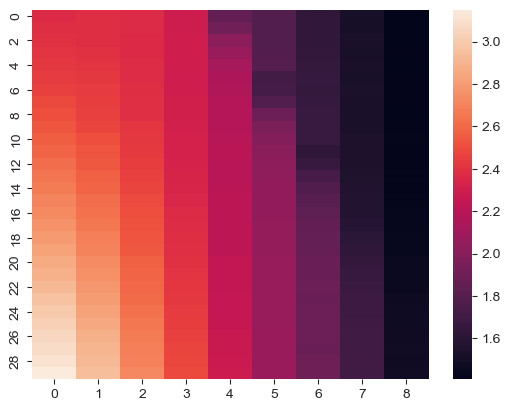

In [41]:
sns.heatmap(Max_matrix)

30

# Better code

In [1]:
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import fullmodel_v1_7
import pandas as pd
from Extract_data import extractData
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from multiprocess import Pool
import os
import time
import copy

In [2]:
# Define your ODE function

# Initial conditions
M_0 = 0
A_0 = 0.5
B_0 = 0.004  # 0.004
Q_B_0 = 0.01
Q_A_0 = 0.01
P_0 = 0.7  # 10
D_0 = 0.0239  # 0.0239
Y_0 = 0.025
W_0 = 0.02
O_0 = 7
v_A_0 = 0
v_D_0 = 0
v_Y_0 = 0
v_W_0 = 0


initial_conditions = [M_0, B_0, A_0,
                      Q_B_0,
                      Q_A_0, P_0,
                      D_0,
                      Y_0, W_0,
                      v_A_0, v_D_0,
                      v_Y_0, v_W_0, O_0]


# Data
year = "2021"
data = pd.read_excel("all-bloom-indicators.xlsx")

lake_name = "Pigeon Lake"

data = data[data["Waterbody name"] == lake_name]

data_fit = extractData(data, year)




def read_params():
    model_CyB = fullmodel_v1_7.modelCyB()
    model_CyB.initial = initial_conditions
    name_data_param = "fitting_parameters_full_variables_v1"
    coment = "_v1_7_"
    name_data = './New data/'+lake_name + '/' \
        + name_data_param + year + lake_name+coment \
        + "_final" + ".csv"

    params_fit = pd.read_csv(name_data)

    # params_fit = pd.read_csv(
    #     "fitting_parameters_full_variables_v12021Pine Lake_v2__final.csv")
    unknow_params = ["e_BD", "alpha_B", "alpha_D",
                     "alpha_Y",
                     "tau_B", "tau_D", "tau_Y",
                     "a_A", "a_D", "sigma_A",
                     "sigma_D", "x_A", "x_D"]

    model_CyB.initial[1] = params_fit["B_0"][0]
    model_CyB.initial[2] = params_fit["A_0"][0]
    model_CyB.initial[6] = params_fit["D_0"][0]

    for name in unknow_params:
        model_CyB.params[name] = params_fit[name][0]

    # Death Daphnia
    model_CyB.params['n_D'] = 0.0623
    model_CyB.params['e_BD'] = 0.8
    model_CyB.params["tau_B"] = 1.23
    model_CyB.params["alpha_B"] = 0.0035
    # model_CyB.params["tau_Y"] = 1.23
    # # model_CyB.params["tau_D"] = 0.01
    # model_CyB.params["alpha_D"] = 0.003941
    # model_CyB.params['phi_D'] = 700
    # model_CyB.params['phi_Y'] = 700

    model_CyB.params['r_Y'] = 2
    model_CyB.params['r_W'] = 1
    model_CyB.params['Ext_Y'] = 0.025*13
    model_CyB.params['Ext_W'] = 0.025
    # model_CyB.params['p_in'] = 0.15*2

    # With Toxine
    model_CyB.toxines = True and (model_CyB.initial[1] > 0)
    # New time scale
    # days_before = 15

    # days_after = 60

    model_CyB.t_0 = 0

    # model_CyB.t_f = t_data.max()-t_data.min() + days_after

    model_CyB.t_f = 365

    model_CyB.delta_t = model_CyB.t_f*3

    model_CyB.set_linetime()

    t_data = data_fit["days"].values

    # Temperature

    model_CyB.max_temp_time = 197.3989-20

    return model_CyB

C:\Users\brian\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["Total cyanobacterial cell count (cells/mL)Tra"] = transformCyB(
C:\Users\brian\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["days"] = data_mean_year.index.dayofyear


# Processing

In [7]:
import numpy as np
import pandas as pd
from multiprocess import Pool
from scipy.optimize import curve_fit
import time
from Extract_data import extractData  # Assuming this function exists in Extract_data module
import copy
import os

# Constants
MAP_COLOR = "inferno"
SAVE_HEAT = False
SAVE_HEAT_SUB = True
HEAT_MAP_Z_MD_E_SPP2 = True
TEMP = 0.6
THRESHOLD = 10
NUM_PROCESSES = 6 # os.cpu_count()
path_max = 'SSP_dE_zm_max_'+str(TEMP)+'.csv'
path_mean = 'SSP_dE_zm_mean_' + str(TEMP) + '.csv'

Z_values = list(np.around(np.arange(1, 10+0.1, 0.05), 2))
d_values = list(np.around(np.arange(0.02, 0.08+0.0005, 0.0005), 4))


def days_before_after_toxin(M_values, threhold):
    # Find indices where elements are greater than b
    greater_than_b_indices = np.where(M_values > threhold)[0]

    if len(greater_than_b_indices) == 0:
        return None, None  # No elements greater than b

    # First index where element is greater than b
    x_0 = greater_than_b_indices[0]

    # Last index where element is greater than b
    x_1 = greater_than_b_indices[-1]

    return int(x_0/3), int(x_1/3)


def Avarage_max_peaks(B, x_0, x_1, model_CyB):
    if x_0 == None or x_1 == None:
        return 0
    else:
        avar = np.trapz(B[x_0*3:x_1*3],
                        model_CyB.t[x_0*3:x_1*3])\
            / (x_1 - x_0)
        return avar




# Define solve_model function
def solve_model(model, d_E, z_m):
    import copy
    from scipy.optimize import curve_fit
    import numpy as np
    THRESHOLD = 10
    
    def days_before_after_toxin(M_values, threshold):
        indices = np.where(M_values > threshold)[0]
        if len(indices) == 0:
            return None, None
        x_0 = indices[0]
        x_1 = indices[-1]
        return int(x_0 / 3), int(x_1 / 3)

    def average_max_peaks(B, x_0, x_1):
        if x_0 is None or x_1 is None:
            return 0
        return np.trapz(B[x_0 * 3:x_1 * 3], model.t[x_0 * 3:x_1 * 3]) / (x_1 - x_0)

    model_copy = copy.deepcopy(model)
    model_copy.params['d_E'] = d_E
    model_copy.params['z_mk_A'] = (z_m * 0.0004) * 1000
    model_copy.params['z_mk_B'] = (z_m * 0.0004) * 1000
    model_copy.params['z_mK_bg'] = (z_m * 0.3)
    solution, _ = model_copy.solver()
    M_values, _, _, _, _, _, _, _, _, _, _, _, _, _ = solution.T
    x_0, x_1 = days_before_after_toxin(M_values, THRESHOLD)
    return average_max_peaks(M_values, x_0, x_1)
# Main function
def main():
    tic = time.time()

    if HEAT_MAP_Z_MD_E_SPP2:
        pool = Pool(NUM_PROCESSES)
        path_max = f'SSP2_dE_zm_max_{TEMP}.csv'
        path_mean = f'SSP2_dE_zm_mean_{TEMP}.csv'

        model_CyB_base = read_params()
        solution_base, _ = model_CyB_base.solver()
        M_values_base, _, _, _, _, _, _, _, _, _, _, _, _, _ = solution_base.T
        x_0_base, x_1_base = days_before_after_toxin(M_values_base, THRESHOLD)
        avar_base = Avarage_max_peaks(M_values_base, x_0_base, x_1_base, model_CyB_base)

        model_CyB_max = read_params()
        model_CyB_mean = read_params()

        days_temp = np.array([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])
        temp_water = np.array([7.35, 7.3, 7.91, 9.4, 11.67, 13.59, 15.49, 16.02, 14.08, 11.29, 9.26, 8.07])
        temp_water[temp_water > 11] += TEMP  # Add TEMP to temperatures above 11
        bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])
        initial_guess = [15, 0, 200, 7]
        def temperature(t, K, T, t_0, k_0):
            return K*np.exp(-T*(t-t_0)**2)+k_0
        params, _ = curve_fit(temperature, days_temp, temp_water, p0=initial_guess, bounds=bounds)
        model_CyB_max.max_temp = round(params[0], 5)
        model_CyB_max.min_temp = round(params[3], 5)
        model_CyB_max.max_temp_time = round(params[2] - 20, 5)
        model_CyB_max.T = round(params[1], 5)
        min_temp = model_CyB_base.min_temp
        model_CyB_mean.min_temp = min_temp + TEMP

        # Iterate over d_values and Z_values in parallel
        results_max = []
        results_mean = []
        for d_E in d_values:
            async_results_max = []
            async_results_mean = []
            print('Processing...d_E', d_E)
            for z_m in Z_values:
                async_result_max = pool.apply_async(
                    solve_model, (model_CyB_max, d_E, z_m))  # Provide d_E and z_m here
                async_results_max.append(async_result_max)
                async_result_mean = pool.apply_async(
                    solve_model, (model_CyB_mean, d_E, z_m))  # Provide d_E and z_m here
                async_results_mean.append(async_result_mean)
            results_max.append([async_result_max.get()
                               for async_result_max in async_results_max])
            results_mean.append([async_result_mean.get()
                                for async_result_mean in async_results_mean])

            if SAVE_HEAT_SUB:
                Max_data = pd.DataFrame(np.array(results_max) / avar_base)
                Max_data.to_csv(path_max)
                Mean_data = pd.DataFrame(np.array(results_mean) / avar_base)
                Mean_data.to_csv(path_mean)
                print('Save Data SSP until Temp and d_E: ' + str(TEMP), d_E)

        pool.close()
        pool.join()

        Max_matrix = np.array(results_max) / avar_base
        Mean_matrix = np.array(results_mean) / avar_base

        if SAVE_HEAT:
            Max_data = pd.DataFrame(Max_matrix)
            Max_data.to_csv(path_max)
            Mean_data = pd.DataFrame(Mean_matrix)
            Mean_data.to_csv(path_mean)

    toc = time.time()
    print(f'Completed in {toc - tic} seconds')
    return Max_matrix, Mean_matrix
if __name__ == "__main__":
    Max_matrix, Mean_matrix = main()

Processing...d_E 0.02
Save Data SSP until Temp and d_E: 0.6 0.02
Processing...d_E 0.0205
Save Data SSP until Temp and d_E: 0.6 0.0205
Processing...d_E 0.021
Save Data SSP until Temp and d_E: 0.6 0.021
Processing...d_E 0.0215
Save Data SSP until Temp and d_E: 0.6 0.0215
Processing...d_E 0.022
Save Data SSP until Temp and d_E: 0.6 0.022
Processing...d_E 0.0225
Save Data SSP until Temp and d_E: 0.6 0.0225
Processing...d_E 0.023
Save Data SSP until Temp and d_E: 0.6 0.023
Processing...d_E 0.0235
Save Data SSP until Temp and d_E: 0.6 0.0235
Processing...d_E 0.024
Save Data SSP until Temp and d_E: 0.6 0.024
Processing...d_E 0.0245
Save Data SSP until Temp and d_E: 0.6 0.0245
Processing...d_E 0.025
Save Data SSP until Temp and d_E: 0.6 0.025
Processing...d_E 0.0255
Save Data SSP until Temp and d_E: 0.6 0.0255
Processing...d_E 0.026
Save Data SSP until Temp and d_E: 0.6 0.026
Processing...d_E 0.0265
Save Data SSP until Temp and d_E: 0.6 0.0265
Processing...d_E 0.027
Save Data SSP until Temp an

<Axes: >

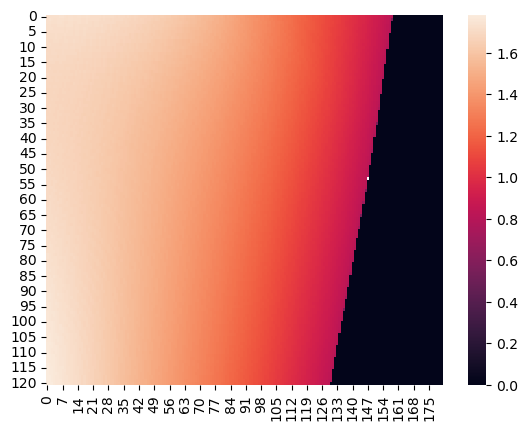

In [8]:
sns.heatmap(Max_matrix)

# Several Temperatures
### Vulneravity index from 152 to 244 in 2021 (Summer from https://www.travelalberta.com/know-before-you-go/climate-weather#:~:text=Summer%20(June%20%2D%20September)%20Seasonal,or%20exploring%20the%20urban%20landscapes.)

In [1]:
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import fullmodel_v1_7
import pandas as pd
from Extract_data import extractData
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from multiprocess import Pool
import os
import time
import copy

In [2]:
# Define your ODE function

# Initial conditions
M_0 = 0
A_0 = 0.5
B_0 = 0.004  # 0.004
Q_B_0 = 0.01
Q_A_0 = 0.01
P_0 = 0.7  # 10
D_0 = 0.0239  # 0.0239
Y_0 = 0.025
W_0 = 0.02
O_0 = 7
v_A_0 = 0
v_D_0 = 0
v_Y_0 = 0
v_W_0 = 0


initial_conditions = [M_0, B_0, A_0,
                      Q_B_0,
                      Q_A_0, P_0,
                      D_0,
                      Y_0, W_0,
                      v_A_0, v_D_0,
                      v_Y_0, v_W_0, O_0]


# Data
year = "2021"
data = pd.read_excel("all-bloom-indicators.xlsx")

lake_name = "Pigeon Lake"

data = data[data["Waterbody name"] == lake_name]

data_fit = extractData(data, year)




def read_params():
    model_CyB = fullmodel_v1_7.modelCyB()
    model_CyB.initial = initial_conditions
    name_data_param = "fitting_parameters_full_variables_v1"
    coment = "_v1_7_"
    name_data = './New data/'+lake_name + '/' \
        + name_data_param + year + lake_name+coment \
        + "_final" + ".csv"

    params_fit = pd.read_csv(name_data)

    # params_fit = pd.read_csv(
    #     "fitting_parameters_full_variables_v12021Pine Lake_v2__final.csv")
    unknow_params = ["e_BD", "alpha_B", "alpha_D",
                     "alpha_Y",
                     "tau_B", "tau_D", "tau_Y",
                     "a_A", "a_D", "sigma_A",
                     "sigma_D", "x_A", "x_D"]

    model_CyB.initial[1] = params_fit["B_0"][0]
    model_CyB.initial[2] = params_fit["A_0"][0]
    model_CyB.initial[6] = params_fit["D_0"][0]

    for name in unknow_params:
        model_CyB.params[name] = params_fit[name][0]

    # Death Daphnia
    model_CyB.params['n_D'] = 0.0623
    model_CyB.params['e_BD'] = 0.8
    model_CyB.params["tau_B"] = 1.23
    model_CyB.params["alpha_B"] = 0.0035
    # model_CyB.params["tau_Y"] = 1.23
    # # model_CyB.params["tau_D"] = 0.01
    # model_CyB.params["alpha_D"] = 0.003941
    # model_CyB.params['phi_D'] = 700
    # model_CyB.params['phi_Y'] = 700

    model_CyB.params['r_Y'] = 2
    model_CyB.params['r_W'] = 1
    model_CyB.params['Ext_Y'] = 0.025*13
    model_CyB.params['Ext_W'] = 0.025
    model_CyB.t_0 = 0
    model_CyB.t_f = 365
    model_CyB.delta_t = model_CyB.t_f*3
    model_CyB.set_linetime()
    t_data = data_fit["days"].values
    # Temperature
    model_CyB.max_temp_time = 197.3989-20
    return model_CyB

C:\Users\brian\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["Total cyanobacterial cell count (cells/mL)Tra"] = transformCyB(
C:\Users\brian\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["days"] = data_mean_year.index.dayofyear


# Processing

In [5]:
import numpy as np
import pandas as pd
from multiprocess import Pool
from scipy.optimize import curve_fit
import time
from Extract_data import extractData  # Assuming this function exists in Extract_data module
import copy
import os

# Constants
MAP_COLOR = "inferno"
SAVE_HEAT = False
SAVE_HEAT_SUB = True
HEAT_MAP_Z_MD_E_SPP2 = True
# TEMP = 0.6
THRESHOLD = 10
NUM_PROCESSES = 8 # os.cpu_count()
START_DAY = 121
END_DAY =  273

Z_values = list(np.around(np.arange(1, 10+0.1, 0.05), 2))
d_values = list(np.around(np.arange(0.02, 0.08+0.0005, 0.0005), 4))


def days_before_after_toxin(M_values, threhold):
    return START_DAY, END_DAY


def Avarage_max_peaks(B, x_0, x_1, model_CyB):
    if x_0 == None or x_1 == None:
        return 0
    else:
        avar = np.trapz(B[x_0*3:x_1*3],
                        model_CyB.t[x_0*3:x_1*3])\
            / (x_1 - x_0)
        return avar




# Define solve_model function
def solve_model(model, d_E, z_m):
    import copy
    from scipy.optimize import curve_fit
    import numpy as np
    THRESHOLD = 10
    START_DAY = 121
    END_DAY =  273
    
    def days_before_after_toxin(M_values, threshold):
        return START_DAY, END_DAY

    def average_max_peaks(B, x_0, x_1):
        if x_0 is None or x_1 is None:
            return 0
        return np.trapz(B[x_0 * 3:x_1 * 3], model.t[x_0 * 3:x_1 * 3]) / (x_1 - x_0)

    model_copy = copy.deepcopy(model)
    model_copy.params['d_E'] = d_E
    model_copy.params['z_mk_A'] = (z_m * 0.0004) * 1000
    model_copy.params['z_mk_B'] = (z_m * 0.0004) * 1000
    model_copy.params['z_mK_bg'] = (z_m * 0.3)
    solution, _ = model_copy.solver()
    M_values, _, _, _, _, _, _, _, _, _, _, _, _, _ = solution.T
    x_0, x_1 = days_before_after_toxin(M_values, THRESHOLD)
    return average_max_peaks(M_values, x_0, x_1)
# Main function
def main(TEMP):
    tic = time.time()
    path_max = 'SSP_dE_zm_max_'+str(TEMP)+'.csv'
    path_mean = 'SSP_dE_zm_mean_' + str(TEMP) + '.csv'
    if HEAT_MAP_Z_MD_E_SPP2:
        pool = Pool(NUM_PROCESSES)
        path_max = f'SSP2_dE_zm_max_{TEMP}.csv'
        path_mean = f'SSP2_dE_zm_mean_{TEMP}.csv'

        model_CyB_base = read_params()
        solution_base, _ = model_CyB_base.solver()
        M_values_base, _, _, _, _, _, _, _, _, _, _, _, _, _ = solution_base.T
        x_0_base, x_1_base = days_before_after_toxin(M_values_base, THRESHOLD)
        avar_base = Avarage_max_peaks(M_values_base, x_0_base, x_1_base, model_CyB_base)

        model_CyB_max = read_params()
        model_CyB_mean = read_params()

        days_temp = np.array([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])
        temp_water = np.array([7.35, 7.3, 7.91, 9.4, 11.67, 13.59, 15.49, 16.02, 14.08, 11.29, 9.26, 8.07])
        temp_water[temp_water > 11] += TEMP  # Add TEMP to temperatures above 11
        bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])
        initial_guess = [15, 0, 200, 7]
        def temperature(t, K, T, t_0, k_0):
            return K*np.exp(-T*(t-t_0)**2)+k_0
        params, _ = curve_fit(temperature, days_temp, temp_water, p0=initial_guess, bounds=bounds)
        model_CyB_max.max_temp = round(params[0], 5)
        model_CyB_max.min_temp = round(params[3], 5)
        model_CyB_max.max_temp_time = round(params[2] - 20, 5)
        model_CyB_max.T = round(params[1], 5)
        min_temp = model_CyB_base.min_temp
        model_CyB_mean.min_temp = min_temp + TEMP

        # Iterate over d_values and Z_values in parallel
        results_max = []
        results_mean = []
        for d_E in d_values:
            async_results_max = []
            async_results_mean = []
            print('Processing...d_E', d_E)
            for z_m in Z_values:
                async_result_max = pool.apply_async(
                    solve_model, (model_CyB_max, d_E, z_m))  # Provide d_E and z_m here
                async_results_max.append(async_result_max)
                async_result_mean = pool.apply_async(
                    solve_model, (model_CyB_mean, d_E, z_m))  # Provide d_E and z_m here
                async_results_mean.append(async_result_mean)
            results_max.append([async_result_max.get()
                               for async_result_max in async_results_max])
            results_mean.append([async_result_mean.get()
                                for async_result_mean in async_results_mean])

            if SAVE_HEAT_SUB:
                Max_data = pd.DataFrame(np.array(results_max) / avar_base)
                Max_data.to_csv(path_max)
                Mean_data = pd.DataFrame(np.array(results_mean) / avar_base)
                Mean_data.to_csv(path_mean)
                print('Save Data SSP until Temp and d_E: ' + str(TEMP), d_E)

        pool.close()
        pool.join()

        Max_matrix = np.array(results_max) / avar_base
        Mean_matrix = np.array(results_mean) / avar_base

        if SAVE_HEAT:
            Max_data = pd.DataFrame(Max_matrix)
            Max_data.to_csv(path_max)
            Mean_data = pd.DataFrame(Mean_matrix)
            Mean_data.to_csv(path_mean)

    toc = time.time()
    print(f'Completed in {toc - tic} seconds')
    return Max_matrix, Mean_matrix

In [6]:
SSP_temp = [0.6,0.4,1.0,1.7,1.4,3.4]
for TEMP in SSP_temp:
    print('Processing Temp: ', TEMP)
    main(TEMP)

Processing Temp:  0.6
Processing...d_E 0.02
Save Data SSP until Temp and d_E: 0.6 0.02
Processing...d_E 0.0205
Save Data SSP until Temp and d_E: 0.6 0.0205
Processing...d_E 0.021
Save Data SSP until Temp and d_E: 0.6 0.021
Processing...d_E 0.0215
Save Data SSP until Temp and d_E: 0.6 0.0215
Processing...d_E 0.022
Save Data SSP until Temp and d_E: 0.6 0.022
Processing...d_E 0.0225
Save Data SSP until Temp and d_E: 0.6 0.0225
Processing...d_E 0.023
Save Data SSP until Temp and d_E: 0.6 0.023
Processing...d_E 0.0235
Save Data SSP until Temp and d_E: 0.6 0.0235
Processing...d_E 0.024
Save Data SSP until Temp and d_E: 0.6 0.024
Processing...d_E 0.0245
Save Data SSP until Temp and d_E: 0.6 0.0245
Processing...d_E 0.025
Save Data SSP until Temp and d_E: 0.6 0.025
Processing...d_E 0.0255
Save Data SSP until Temp and d_E: 0.6 0.0255
Processing...d_E 0.026
Save Data SSP until Temp and d_E: 0.6 0.026
Processing...d_E 0.0265
Save Data SSP until Temp and d_E: 0.6 0.0265
Processing...d_E 0.027
Save 

# Maximum concetration of Microsysten-LR 

In [1]:
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import fullmodel_v1_7
import pandas as pd
from Extract_data import extractData
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from multiprocess import Pool
import os
import time
import copy

In [2]:
# Define your ODE function

# Initial conditions
M_0 = 0
A_0 = 0.5
B_0 = 0.004  # 0.004
Q_B_0 = 0.01
Q_A_0 = 0.01
P_0 = 0.7  # 10
D_0 = 0.0239  # 0.0239
Y_0 = 0.025
W_0 = 0.02
O_0 = 7
v_A_0 = 0
v_D_0 = 0
v_Y_0 = 0
v_W_0 = 0


initial_conditions = [M_0, B_0, A_0,
                      Q_B_0,
                      Q_A_0, P_0,
                      D_0,
                      Y_0, W_0,
                      v_A_0, v_D_0,
                      v_Y_0, v_W_0, O_0]


# Data
year = "2021"
data = pd.read_excel("all-bloom-indicators.xlsx")

lake_name = "Pigeon Lake"

data = data[data["Waterbody name"] == lake_name]

data_fit = extractData(data, year)




def read_params():
    model_CyB = fullmodel_v1_7.modelCyB()
    model_CyB.initial = initial_conditions
    name_data_param = "fitting_parameters_full_variables_v1"
    coment = "_v1_7_"
    name_data = './New data/'+lake_name + '/' \
        + name_data_param + year + lake_name+coment \
        + "_final" + ".csv"

    params_fit = pd.read_csv(name_data)

    # params_fit = pd.read_csv(
    #     "fitting_parameters_full_variables_v12021Pine Lake_v2__final.csv")
    unknow_params = ["e_BD", "alpha_B", "alpha_D",
                     "alpha_Y",
                     "tau_B", "tau_D", "tau_Y",
                     "a_A", "a_D", "sigma_A",
                     "sigma_D", "x_A", "x_D"]

    model_CyB.initial[1] = params_fit["B_0"][0]
    model_CyB.initial[2] = params_fit["A_0"][0]
    model_CyB.initial[6] = params_fit["D_0"][0]

    for name in unknow_params:
        model_CyB.params[name] = params_fit[name][0]

    # Death Daphnia
    model_CyB.params['n_D'] = 0.0623
    model_CyB.params['e_BD'] = 0.8
    model_CyB.params["tau_B"] = 1.23
    model_CyB.params["alpha_B"] = 0.0035
    # model_CyB.params["tau_Y"] = 1.23
    # # model_CyB.params["tau_D"] = 0.01
    # model_CyB.params["alpha_D"] = 0.003941
    # model_CyB.params['phi_D'] = 700
    # model_CyB.params['phi_Y'] = 700

    model_CyB.params['r_Y'] = 2
    model_CyB.params['r_W'] = 1
    model_CyB.params['Ext_Y'] = 0.025*13
    model_CyB.params['Ext_W'] = 0.025
    model_CyB.t_0 = 0
    model_CyB.t_f = 365
    model_CyB.delta_t = model_CyB.t_f*3
    model_CyB.set_linetime()
    t_data = data_fit["days"].values
    # Temperature
    model_CyB.max_temp_time = 197.3989-20
    return model_CyB

C:\Users\brian\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["Total cyanobacterial cell count (cells/mL)Tra"] = transformCyB(
C:\Users\brian\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["days"] = data_mean_year.index.dayofyear


## Processing

In [5]:
import numpy as np
import pandas as pd
from multiprocess import Pool
from scipy.optimize import curve_fit
import time
from Extract_data import extractData  # Assuming this function exists in Extract_data module
import copy
import os

# Constants
MAP_COLOR = "inferno"
SAVE_HEAT = False
SAVE_HEAT_SUB = True
HEAT_MAP_Z_MD_E_SPP2 = True
# TEMP = 0.6
THRESHOLD = 10
NUM_PROCESSES = 6 # os.cpu_count()
# START_DAY = 121
# END_DAY =  273

Z_values = list(np.around(np.arange(1, 10+0.1, 0.05), 2))
d_values = list(np.around(np.arange(0.02, 0.08+0.0005, 0.0005), 4))





# Define solve_model function
def solve_model(model, d_E, z_m):
    import copy
    from scipy.optimize import curve_fit
    import numpy as np

    model_copy = copy.deepcopy(model)
    model_copy.params['d_E'] = d_E
    model_copy.params['z_mk_A'] = (z_m * 0.0004) * 1000
    model_copy.params['z_mk_B'] = (z_m * 0.0004) * 1000
    model_copy.params['z_mK_bg'] = (z_m * 0.3)
    solution, _ = model_copy.solver()
    M_values, _, _, _, _, _, _, _, _, _, _, _, _, _ = solution.T
    
    return M_values.max()
# Main function
def main(TEMP):
    tic = time.time()
    if HEAT_MAP_Z_MD_E_SPP2:
        pool = Pool(NUM_PROCESSES)
        path_max = f'SSP2_dE_zm_max_maximumValue_{TEMP}.csv'
        path_mean = f'SSP2_dE_zm_mean_maximumValues_{TEMP}.csv'

        model_CyB_base = read_params()
        solution_base, _ = model_CyB_base.solver()
        M_values_base, _, _, _, _, _, _, _, _, _, _, _, _, _ = solution_base.T
       
        Max_base = M_values_base.max()

        model_CyB_max = read_params()
        model_CyB_mean = read_params()

        days_temp = np.array([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])
        temp_water = np.array([7.35, 7.3, 7.91, 9.4, 11.67, 13.59, 15.49, 16.02, 14.08, 11.29, 9.26, 8.07])
        temp_water[temp_water > 11] += TEMP  # Add TEMP to temperatures above 11
        bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])
        initial_guess = [15, 0, 200, 7]
        def temperature(t, K, T, t_0, k_0):
            return K*np.exp(-T*(t-t_0)**2)+k_0
        params, _ = curve_fit(temperature, days_temp, temp_water, p0=initial_guess, bounds=bounds)
        model_CyB_max.max_temp = round(params[0], 5)
        model_CyB_max.min_temp = round(params[3], 5)
        model_CyB_max.max_temp_time = round(params[2] - 20, 5)
        model_CyB_max.T = round(params[1], 5)
        min_temp = model_CyB_base.min_temp
        model_CyB_mean.min_temp = min_temp + TEMP

        # Iterate over d_values and Z_values in parallel
        results_max = []
        results_mean = []
        for d_E in d_values:
            async_results_max = []
            async_results_mean = []
            print('Processing...d_E', d_E)
            for z_m in Z_values:
                async_result_max = pool.apply_async(
                    solve_model, (model_CyB_max, d_E, z_m))  # Provide d_E and z_m here
                async_results_max.append(async_result_max)
                async_result_mean = pool.apply_async(
                    solve_model, (model_CyB_mean, d_E, z_m))  # Provide d_E and z_m here
                async_results_mean.append(async_result_mean)
            results_max.append([async_result_max.get()
                               for async_result_max in async_results_max])
            results_mean.append([async_result_mean.get()
                                for async_result_mean in async_results_mean])

            if SAVE_HEAT_SUB:
                Max_data = pd.DataFrame(np.array(results_max) / Max_base)
                Max_data.to_csv(path_max)
                Mean_data = pd.DataFrame(np.array(results_mean) / Max_base)
                Mean_data.to_csv(path_mean)
                print('Save Data SSP until Temp and d_E: ' + str(TEMP), d_E)
                print('Save on', path_max)

        pool.close()
        pool.join()

        Max_matrix = np.array(results_max)
        if SAVE_HEAT:
            Max_data = pd.DataFrame(Max_matrix/ Max_base)
            Max_data.to_csv(path_max)

    toc = time.time()
    print(f'Completed in {toc - tic} seconds')
    return Max_matrix

In [6]:
SSP_temp = [0.6,0.4,1.0,1.7,1.4,3.4]
SSP_temp = [1.0,1.7,1.4,3.4]
for TEMP in SSP_temp:
    print('Processing Temp: ', TEMP)
    main(TEMP)

Processing Temp:  1.0
Processing...d_E 0.02
Save Data SSP until Temp and d_E: 1.0 0.02
Save on SSP2_dE_zm_max_maximumValue_1.0.csv
Processing...d_E 0.0205
Save Data SSP until Temp and d_E: 1.0 0.0205
Save on SSP2_dE_zm_max_maximumValue_1.0.csv
Processing...d_E 0.021
Save Data SSP until Temp and d_E: 1.0 0.021
Save on SSP2_dE_zm_max_maximumValue_1.0.csv
Processing...d_E 0.0215
Save Data SSP until Temp and d_E: 1.0 0.0215
Save on SSP2_dE_zm_max_maximumValue_1.0.csv
Processing...d_E 0.022
Save Data SSP until Temp and d_E: 1.0 0.022
Save on SSP2_dE_zm_max_maximumValue_1.0.csv
Processing...d_E 0.0225
Save Data SSP until Temp and d_E: 1.0 0.0225
Save on SSP2_dE_zm_max_maximumValue_1.0.csv
Processing...d_E 0.023
Save Data SSP until Temp and d_E: 1.0 0.023
Save on SSP2_dE_zm_max_maximumValue_1.0.csv
Processing...d_E 0.0235
Save Data SSP until Temp and d_E: 1.0 0.0235
Save on SSP2_dE_zm_max_maximumValue_1.0.csv
Processing...d_E 0.024
Save Data SSP until Temp and d_E: 1.0 0.024
Save on SSP2_dE_z

24

# Phosphorus Vs Temperature average 

In [1]:
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import fullmodel_v1_7
import pandas as pd
from Extract_data import extractData
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from multiprocess import Pool
import os
import time
import copy

In [2]:
# Define your ODE function

# Initial conditions
M_0 = 0
A_0 = 0.5
B_0 = 0.004  # 0.004
Q_B_0 = 0.01
Q_A_0 = 0.01
P_0 = 0.7  # 10
D_0 = 0.0239  # 0.0239
Y_0 = 0.025
W_0 = 0.02
O_0 = 7
v_A_0 = 0
v_D_0 = 0
v_Y_0 = 0
v_W_0 = 0


initial_conditions = [M_0, B_0, A_0,
                      Q_B_0,
                      Q_A_0, P_0,
                      D_0,
                      Y_0, W_0,
                      v_A_0, v_D_0,
                      v_Y_0, v_W_0, O_0]


# Data
year = "2021"
data = pd.read_excel("all-bloom-indicators.xlsx")

lake_name = "Pigeon Lake"

data = data[data["Waterbody name"] == lake_name]

data_fit = extractData(data, year)




def read_params():
    model_CyB = fullmodel_v1_7.modelCyB()
    model_CyB.initial = initial_conditions
    name_data_param = "fitting_parameters_full_variables_v1"
    coment = "_v1_7_"
    name_data = './New data/'+lake_name + '/' \
        + name_data_param + year + lake_name+coment \
        + "_final" + ".csv"

    params_fit = pd.read_csv(name_data)

    # params_fit = pd.read_csv(
    #     "fitting_parameters_full_variables_v12021Pine Lake_v2__final.csv")
    unknow_params = ["e_BD", "alpha_B", "alpha_D",
                     "alpha_Y",
                     "tau_B", "tau_D", "tau_Y",
                     "a_A", "a_D", "sigma_A",
                     "sigma_D", "x_A", "x_D"]

    model_CyB.initial[1] = params_fit["B_0"][0]
    model_CyB.initial[2] = params_fit["A_0"][0]
    model_CyB.initial[6] = params_fit["D_0"][0]

    for name in unknow_params:
        model_CyB.params[name] = params_fit[name][0]

    # Death Daphnia
    model_CyB.params['n_D'] = 0.0623
    model_CyB.params['e_BD'] = 0.8
    model_CyB.params["tau_B"] = 1.23
    model_CyB.params["alpha_B"] = 0.0035
    # model_CyB.params["tau_Y"] = 1.23
    # # model_CyB.params["tau_D"] = 0.01
    # model_CyB.params["alpha_D"] = 0.003941
    # model_CyB.params['phi_D'] = 700
    # model_CyB.params['phi_Y'] = 700

    model_CyB.params['r_Y'] = 2
    model_CyB.params['r_W'] = 1
    model_CyB.params['Ext_Y'] = 0.025*13
    model_CyB.params['Ext_W'] = 0.025
    model_CyB.t_0 = 0
    model_CyB.t_f = 365
    model_CyB.delta_t = model_CyB.t_f*3
    model_CyB.set_linetime()
    t_data = data_fit["days"].values
    # Temperature
    model_CyB.max_temp_time = 197.3989-20
    return model_CyB

C:\Users\brian\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["Total cyanobacterial cell count (cells/mL)Tra"] = transformCyB(
C:\Users\brian\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["days"] = data_mean_year.index.dayofyear


In [3]:
import numpy as np
import pandas as pd
from multiprocess import Pool
from scipy.optimize import curve_fit
import time
from Extract_data import extractData  # Assuming this function exists in Extract_data module
import copy
import os

# Constants
MAP_COLOR = "inferno"
SAVE_HEAT = False
SAVE_HEAT_SUB = True
HeatMapPhosTemp = True
# TEMP = 0.6
THRESHOLD = 10
NUM_PROCESSES = 6 # os.cpu_count()
START_DAY = 121
END_DAY =  273


d_temp = 0.02
Temp = np.around(np.arange(0, 3.4+d_temp, d_temp), decimals=2)

d_p = 0.005
Pin = np.around(np.arange(0.1, 0.8+d_p, d_p), decimals=3)

def days_before_after_toxin(M_values, threhold):
    return START_DAY, END_DAY


def Avarage_max_peaks(B, x_0, x_1, model_CyB):
    if x_0 == None or x_1 == None:
        return 0
    else:
        avar = np.trapz(B[x_0*3:x_1*3],
                        model_CyB.t[x_0*3:x_1*3])\
            / (x_1 - x_0)
        return avar




# Define solve_model function
def solve_model(model, temp, pin):
    import copy
    import numpy as np
    from scipy.optimize import curve_fit
    START_DAY = 121
    END_DAY =  273
    
    def days_before_after_toxin(M_values):
        return START_DAY, END_DAY

    def average_max_peaks(B, x_0, x_1):
        if x_0 is None or x_1 is None:
            return 0
        return np.trapz(B[x_0 * 3:x_1 * 3], model.t[x_0 * 3:x_1 * 3]) / (x_1 - x_0)

    model_copy = copy.deepcopy(model)
    model_copy.initial[5] = 0.1
    
    days_temp = np.array([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])
    temp_water = np.array([7.35, 7.3, 7.91, 9.4, 11.67, 13.59, 15.49, 16.02, 14.08, 11.29, 9.26, 8.07])
    temp_water[temp_water > 11] += temp  # Add TEMP to temperatures above 11
    bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])
    initial_guess = [15, 0, 200, 7]
    def temperature(t, K, T, t_0, k_0):
            return K*np.exp(-T*(t-t_0)**2)+k_0
    params, _ = curve_fit(temperature, days_temp, temp_water, p0=initial_guess, bounds=bounds)
    model_copy.max_temp = round(params[0], 5)
    model_copy.min_temp = round(params[3], 5)
    model_copy.max_temp_time = round(params[2] - 20, 5)
    model_copy.T = round(params[1], 5)

    
    model_copy.params['p_in'] = pin
    solution, _ = model_copy.solver()
    M_values, _, _, _, _, _, _, _, _, _, _, _, _, _ = solution.T
    x_0, x_1 = days_before_after_toxin(M_values)
    return average_max_peaks(M_values, x_0, x_1)
# Main function
def main():
    tic = time.time()
    path_max = 'MaxM_pho_max_mean.csv'
    if HeatMapPhosTemp:
        pool = Pool(NUM_PROCESSES)
        model_CyB_max = read_params()
        
        # Iterate over temp and pin in parallel
        results_max = []
        for temp in Temp:
            model_CyB_max = read_params()
            async_results_max = []
            print('Processing...temp', temp)
            for pin in Pin:
                async_result_max = pool.apply_async(
                    solve_model, (model_CyB_max, temp, pin))  # Provide d_E and z_m here
                async_results_max.append(async_result_max)
            results_max.append([async_result_max.get()
                                for async_result_max in async_results_max])

            if SAVE_HEAT_SUB:
                Max_data = pd.DataFrame(np.array(results_max))
                Max_data.to_csv(path_max)
                print('Save Data SSP until Temp and pin: ' + str(temp), pin)

        pool.close()
        pool.join()

        Max_matrix = np.array(results_max)

        if SAVE_HEAT:
            Max_data = pd.DataFrame(Max_matrix)
            Max_data.to_csv(path_max)

    toc = time.time()
    print(f'Completed in {toc - tic} seconds')
    return Max_matrix

In [4]:
main()

Processing...temp 0.0
Save Data SSP until Temp and pin: 0.0 0.8
Processing...temp 0.02
Save Data SSP until Temp and pin: 0.02 0.8
Processing...temp 0.04
Save Data SSP until Temp and pin: 0.04 0.8
Processing...temp 0.06
Save Data SSP until Temp and pin: 0.06 0.8
Processing...temp 0.08
Save Data SSP until Temp and pin: 0.08 0.8
Processing...temp 0.1
Save Data SSP until Temp and pin: 0.1 0.8
Processing...temp 0.12
Save Data SSP until Temp and pin: 0.12 0.8
Processing...temp 0.14
Save Data SSP until Temp and pin: 0.14 0.8
Processing...temp 0.16
Save Data SSP until Temp and pin: 0.16 0.8
Processing...temp 0.18
Save Data SSP until Temp and pin: 0.18 0.8
Processing...temp 0.2
Save Data SSP until Temp and pin: 0.2 0.8
Processing...temp 0.22
Save Data SSP until Temp and pin: 0.22 0.8
Processing...temp 0.24
Save Data SSP until Temp and pin: 0.24 0.8
Processing...temp 0.26
Save Data SSP until Temp and pin: 0.26 0.8
Processing...temp 0.28
Save Data SSP until Temp and pin: 0.28 0.8
Processing...tem

array([[ 2.98281062,  3.05591798,  3.12736642, ...,  5.72329987,
         5.72419759,  5.7248052 ],
       [ 3.01020972,  3.08421358,  3.15654797, ...,  5.78351103,
         5.78452409,  5.78528736],
       [ 3.03766867,  3.11257144,  3.18580368, ...,  5.84374067,
         5.84470276,  5.84559648],
       ...,
       [ 7.9378656 ,  8.18539189,  8.42905284, ..., 13.2197338 ,
        13.19912943, 13.18046668],
       [ 7.96717032,  8.21573077,  8.46037932, ..., 13.25044041,
        13.22973059, 13.21099006],
       [ 7.99644778,  8.24603279,  8.49168739, ..., 13.2811054 ,
        13.26031357, 13.24146346]])

In [10]:
len(Temp)

86

# P(0) vs Pin 

In [1]:
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import fullmodel_v1_7
import pandas as pd
from Extract_data import extractData
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from multiprocess import Pool
import os
import time
import copy

In [2]:
# Define your ODE function

# Initial conditions
M_0 = 0
A_0 = 0.5
B_0 = 0.004  # 0.004
Q_B_0 = 0.01
Q_A_0 = 0.01
P_0 = 0.7  # 10
D_0 = 0.0239  # 0.0239
Y_0 = 0.025
W_0 = 0.02
O_0 = 7
v_A_0 = 0
v_D_0 = 0
v_Y_0 = 0
v_W_0 = 0


initial_conditions = [M_0, B_0, A_0,
                      Q_B_0,
                      Q_A_0, P_0,
                      D_0,
                      Y_0, W_0,
                      v_A_0, v_D_0,
                      v_Y_0, v_W_0, O_0]


# Data
year = "2021"
data = pd.read_excel("all-bloom-indicators.xlsx")

lake_name = "Pigeon Lake"

data = data[data["Waterbody name"] == lake_name]

data_fit = extractData(data, year)




def read_params():
    model_CyB = fullmodel_v1_7.modelCyB()
    model_CyB.initial = initial_conditions
    name_data_param = "fitting_parameters_full_variables_v1"
    coment = "_v1_7_"
    name_data = './New data/'+lake_name + '/' \
        + name_data_param + year + lake_name+coment \
        + "_final" + ".csv"

    params_fit = pd.read_csv(name_data)

    # params_fit = pd.read_csv(
    #     "fitting_parameters_full_variables_v12021Pine Lake_v2__final.csv")
    unknow_params = ["e_BD", "alpha_B", "alpha_D",
                     "alpha_Y",
                     "tau_B", "tau_D", "tau_Y",
                     "a_A", "a_D", "sigma_A",
                     "sigma_D", "x_A", "x_D"]

    model_CyB.initial[1] = params_fit["B_0"][0]
    model_CyB.initial[2] = params_fit["A_0"][0]
    model_CyB.initial[6] = params_fit["D_0"][0]

    for name in unknow_params:
        model_CyB.params[name] = params_fit[name][0]

    # Death Daphnia
    model_CyB.params['n_D'] = 0.0623
    model_CyB.params['e_BD'] = 0.8
    model_CyB.params["tau_B"] = 1.23
    model_CyB.params["alpha_B"] = 0.0035
    # model_CyB.params["tau_Y"] = 1.23
    # # model_CyB.params["tau_D"] = 0.01
    # model_CyB.params["alpha_D"] = 0.003941
    # model_CyB.params['phi_D'] = 700
    # model_CyB.params['phi_Y'] = 700

    model_CyB.params['r_Y'] = 2
    model_CyB.params['r_W'] = 1
    model_CyB.params['Ext_Y'] = 0.025*13
    model_CyB.params['Ext_W'] = 0.025
    model_CyB.t_0 = 0
    model_CyB.t_f = 365
    model_CyB.delta_t = model_CyB.t_f*3
    model_CyB.set_linetime()
    t_data = data_fit["days"].values
    # Temperature
    model_CyB.max_temp_time = 197.3989-20
    return model_CyB

C:\Users\brian\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["Total cyanobacterial cell count (cells/mL)Tra"] = transformCyB(
C:\Users\brian\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["days"] = data_mean_year.index.dayofyear


In [5]:
import numpy as np
import pandas as pd
from multiprocess import Pool
from scipy.optimize import curve_fit
import time
from Extract_data import extractData  # Assuming this function exists in Extract_data module
import copy
import os

# Constants
MAP_COLOR = "inferno"
SAVE_HEAT = False
SAVE_HEAT_SUB = True
HeatMapPhosTemp = True
# TEMP = 0.6
THRESHOLD = 10
NUM_PROCESSES = 6 # os.cpu_count()
START_DAY = 121
END_DAY =  273


P0 = np.around(np.arange(0.01, 0.8+0.005, 0.005), decimals=3)

Pin = np.around(np.arange(0.01, 0.8+0.005, 0.005), decimals=3)

def days_before_after_toxin(M_values, threhold):
    return START_DAY, END_DAY


def Avarage_max_peaks(B, x_0, x_1, model_CyB):
    if x_0 == None or x_1 == None:
        return 0
    else:
        avar = np.trapz(B[x_0*3:x_1*3],
                        model_CyB.t[x_0*3:x_1*3])\
            / (x_1 - x_0)
        return avar




# Define solve_model function
def solve_model(model, p0, pin):
    import copy
    import numpy as np
    START_DAY = 121
    END_DAY =  273
    
    def days_before_after_toxin(M_values):
        return START_DAY, END_DAY

    def average_max_peaks(B, x_0, x_1):
        if x_0 is None or x_1 is None:
            return 0
        return np.trapz(B[x_0 * 3:x_1 * 3], model.t[x_0 * 3:x_1 * 3]) / (x_1 - x_0)

    model_copy = copy.deepcopy(model)
    
    model_copy.initial[5] = p0
    model_copy.params['p_in'] = pin
    solution, _ = model_copy.solver()
    M_values, B_values, _, _, _, _, _, _, _, _, _, _, _, _ = solution.T
    x_0, x_1 = days_before_after_toxin(M_values)
    return average_max_peaks(B_values, x_0, x_1)
# Main function
def main():
    tic = time.time()
    path_max = 'Full_model_heat_MeanCyB.csv'
    if HeatMapPhosTemp:
        pool = Pool(NUM_PROCESSES)
        model_CyB_max = read_params()
        
        # Iterate over temp and pin in parallel
        results_max = []
        for p0 in P0:
            model_CyB_max = read_params()
            async_results_max = []
            print('Processing...temp', p0)
            for pin in Pin:
                async_result_max = pool.apply_async(
                    solve_model, (model_CyB_max, p0, pin))  # Provide d_E and z_m here
                async_results_max.append(async_result_max)
            results_max.append([async_result_max.get()
                                for async_result_max in async_results_max])

            if SAVE_HEAT_SUB:
                Max_data = pd.DataFrame(np.array(results_max))
                Max_data.to_csv(path_max)
                print('Save Data SSP until P0 and pin: ' + str(p0), pin)

        pool.close()
        pool.join()

        Max_matrix = np.array(results_max)

        if SAVE_HEAT:
            Max_data = pd.DataFrame(Max_matrix)
            Max_data.to_csv(path_max)

    toc = time.time()
    print(f'Completed in {toc - tic} seconds')
    return Max_matrix

In [6]:
main()

Processing...temp 0.01
Save Data SSP until P0 and pin: 0.01 0.8
Processing...temp 0.015
Save Data SSP until P0 and pin: 0.015 0.8
Processing...temp 0.02
Save Data SSP until P0 and pin: 0.02 0.8
Processing...temp 0.025
Save Data SSP until P0 and pin: 0.025 0.8
Processing...temp 0.03
Save Data SSP until P0 and pin: 0.03 0.8
Processing...temp 0.035
Save Data SSP until P0 and pin: 0.035 0.8
Processing...temp 0.04
Save Data SSP until P0 and pin: 0.04 0.8
Processing...temp 0.045
Save Data SSP until P0 and pin: 0.045 0.8
Processing...temp 0.05
Save Data SSP until P0 and pin: 0.05 0.8
Processing...temp 0.055
Save Data SSP until P0 and pin: 0.055 0.8
Processing...temp 0.06
Save Data SSP until P0 and pin: 0.06 0.8
Processing...temp 0.065
Save Data SSP until P0 and pin: 0.065 0.8
Processing...temp 0.07
Save Data SSP until P0 and pin: 0.07 0.8
Processing...temp 0.075
Save Data SSP until P0 and pin: 0.075 0.8
Processing...temp 0.08
Save Data SSP until P0 and pin: 0.08 0.8
Processing...temp 0.085
Sa

array([[0.01597655, 0.02320099, 0.03024784, ..., 0.28261518, 0.28102772,
        0.27959229],
       [0.01600478, 0.02323392, 0.03027761, ..., 0.28096109, 0.27953347,
        0.27824919],
       [0.01604092, 0.02327635, 0.03031607, ..., 0.27947144, 0.27819109,
        0.27705119],
       ...,
       [0.27411526, 0.27348283, 0.27295362, ..., 0.27107646, 0.27107771,
        0.27107681],
       [0.27344383, 0.27292598, 0.27249883, ..., 0.27107716, 0.27107713,
        0.27107728],
       [0.27289584, 0.27247542, 0.27213195, ..., 0.27107827, 0.27108002,
        0.27107717]])